<a href="https://colab.research.google.com/github/DataScienceAndEngineering/deep-learning-final-project-project-sidewalk/blob/nicholas/notebooks/data_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Loading all necessary packages
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from google.colab import drive, files
import random
from time import sleep
drive.mount('/content/drive')


# Obtain processed data
if not os.path.isdir('/content/processed_labels/'):
  !unzip -n -q /content/drive/MyDrive/tensorflow_datasets/processed_labels.zip -d /
if not os.path.isdir('/content/processed_images/'):
  !unzip -n -q /content/drive/MyDrive/tensorflow_datasets/processed_images.zip -d /


Mounted at /content/drive


In [ ]:
## Data handling functions

def data_random_split(train=.8, test=.1, val=.1):
  files = os.listdir('/content/processed_images/')
  random.shuffle(files)
  N = len(files)
  train_set = files[0:int(N*train)]
  test_set = files[int(N*train):int(N*train)+int(N*test)]
  val_set = files[int(N*train)+int(N*test):int(N*train)+int(N*test)+int(N*val)]
  return train_set, test_set, val_set

def apply_split(train, test, val):
  #Preparing locations for seperated data
  if not os.path.isdir('/content/seperated_images/'):
    print('constructing directories')
    os.mkdir('/content/seperated_images/')
    os.mkdir('/content/seperated_images/train/')
    os.mkdir('/content/seperated_images/test/')
    os.mkdir('/content/seperated_images/val/')

    os.mkdir('/content/seperated_labels/')
    os.mkdir('/content/seperated_labels/train/')
    os.mkdir('/content/seperated_labels/test/')
    os.mkdir('/content/seperated_labels/val/')      

  data = {'train':train, 'test':test, 'val':val}
  for i in data:
    for j in data[i]:
      os.rename(f'/content/processed_images/{j}', f'/content/seperated_images/{i}/{j}')
      sleep(.001)
      os.rename(f'/content/processed_labels/{j}', f'/content/seperated_labels/{i}/{j}')
      sleep(.001)
    print(f'Completed seperating {i}')



In [ ]:
data_split = data_random_split()
apply_split(data_split[0], data_split[1], data_split[2])


constructing directories
Completed seperating train
Completed seperating test
Completed seperating val


In [ ]:
def dice_coef(y_true, y_pred):
    smooth = 1e-6
    print(np.shape(y_true))
    print(np.shape(y_pred))
    y_true_f = tf.keras.layers.Flatten()(y_true)
    y_pred_f = tf.keras.layers.Flatten()(y_pred)    

    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    denom =(tf.reduce_sum(y_pred_f) + tf.reduce_sum(y_true_f) + smooth)
    return (2. * intersection + smooth) / denom

def dice_score(y_true, y_pred, numLabels=1):
    dice=0
    for index in range(numLabels):
        dice -= dice_coef(y_true[:,:,:,index], y_pred[:,:,:,index])
    return numLabels + dice


In [ ]:
##Input Generator attempt 3 - flow from directory approach
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create a dataframe with the file paths
#data = {'filename': train_images, 'mask': train_masks}
#df = pd.DataFrame(data)

# Define the ImageDataGenerator for the images
image_generator = ImageDataGenerator()

# Define the ImageDataGenerator for the masks
mask_generator = ImageDataGenerator()

# Use the flow_from_dataframe method to load the images and masks
batch_size = 8
image_height = 256
image_width = 512
image_color_mode = 'rgb' # or 'grayscale'
mask_color_mode = 'grayscale'
seed = 42

image_dir = '/content/seperated_images/'
mask_dir = '/content/seperated_labels/'

train_generator = image_generator.flow_from_directory(
    image_dir+'train/',
    target_size=(image_height, image_width),
    batch_size=batch_size,
    color_mode=image_color_mode,
    seed=seed,
    class_mode='binary'
)

mask_flow = mask_generator.flow_from_directory(
    mask_dir+'train/',
    target_size=(image_height, image_width),
    batch_size=batch_size,
    color_mode=mask_color_mode,
    seed=seed
)

train_generator = zip(train_generator, mask_flow)

# Use the train_generator to fit your model with the fit_generator method

model.fit(
    train_generator,
    epochs=10,
)

In [ ]:
## Input Generator Attempt 4 - custom generator approach
class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, list_files, image_dim=(256, 512), batch_size=4, image_path='', label_path=''):
    np.random.seed(0)
    tf.random.set_seed(0)

    self.list_files = list_files
    self.batch_size = batch_size
    self.image_path = image_path
    self.label_path = label_path
    self.image_dim = image_dim
    self.on_epoch_end()

  def __len__(self):
    return int(np.floor(len(self.list_files) / self.batch_size))

  def __getitem__(self, index):
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
    list_files_tmp = [self.list_files[k] for k in indexes]
    X, y = self.data_generation(list_files_tmp)
    return X, y

  def on_epoch_end(self):
    self.indexes = np.arange(len(self.list_files))
    self.current_batch = 0

  def data_generation(self, list_files_tmp):
    y = np.empty((self.batch_size, *self.image_dim, 1))
    X = np.empty((self.batch_size, *self.image_dim, 3))
    for i, ID in enumerate(list_files_tmp):
      #mask = np.array(PIL.Image.open(f'/content/seperated_labels/train/{ID}')).resize(self.image_dim)
      y[i,] = np.load(f'/content/seperated_labels/train/{ID}')
      #y[i,] = np.expand_dims(mask, axis=-1)
      #X[i,] = np.array(PIL.Image.open(f'/content/seperated_images/train/{ID}')).astype('float32').resize(self.image_dim)
      X[i,] = np.load(f'/content/seperated_images/train/{ID}')
    return X, y
  
all_training = os.listdir('/content/seperated_images/train/')
train_generator = DataGenerator(list_files=all_training, image_path='/content/seperated_images/train', label_path='/content/seperated_labels/train/')
    


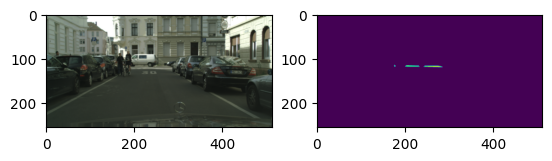

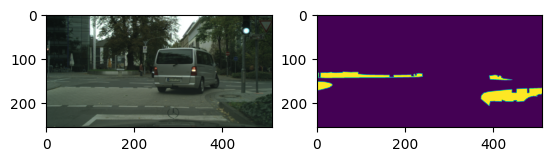

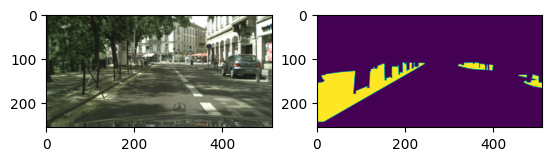

Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x7feb1bed8670>
Traceback (most recent call last):
  File "/usr/lib/python3.9/weakref.py", line 370, in remove
    def remove(k, selfref=ref(self)):
KeyboardInterrupt: 


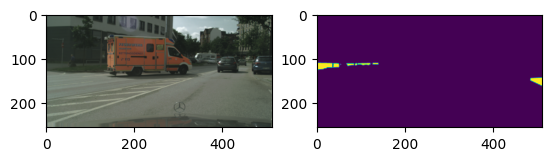

In [10]:
generator = DataGenerator(list_files=all_training, image_path='/content/seperated_images/train', label_path='/content/seperated_labels/train/')
X, y = generator[0]

# plot some samples
for i in range(generator.batch_size):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(X[i])
    plt.subplot(1,2,2)
    plt.imshow(y[i])
    plt.show()

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, Concatenate

def conv_block(inputs, filters, kernel_size=3, activation='relu', padding='same'):
    conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(inputs)
    conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
    return conv

def Unet(input_shape=(256,512,3), num_classes=1):
    inputs = Input(shape=input_shape)

    #Down path
    c1 = conv_block(inputs, 64)
    p1 = MaxPooling2D(pool_size=(2, 2))(c1)

    c2 = conv_block(p1, 128)
    p2 = MaxPooling2D(pool_size=(2, 2))(c2)

    c3 = conv_block(p2, 256)
    p3 = MaxPooling2D(pool_size=(2, 2))(c3)

    c4 = conv_block(p3, 512)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    # Bottom
    c5 = conv_block(p4, 1024)

    #Up path
    u6 = UpSampling2D(size=(2, 2))(c5)
    u6 = Conv2D(512, 2, activation='relu', padding='same')(u6)
    c6 = Concatenate()([u6, c4])
    c6 = conv_block(c6, 512)

    u7 = UpSampling2D(size=(2, 2))(c6)
    u7 = Conv2D(256, 2, activation='relu', padding='same')(u7)
    c7 = Concatenate()([u7, c3])
    c7 = conv_block(c7, 256)

    u8 = UpSampling2D(size=(2, 2))(c7)
    u8 = Conv2D(128, 2, activation='relu', padding='same')(u8)
    c8 = Concatenate()([u8, c2])
    c8 = conv_block(c8, 128)

    u9 = UpSampling2D(size=(2, 2))(c8)
    u9 = Conv2D(64, 2, activation='relu', padding='same')(u9)
    c9 = Concatenate()([u9, c1])
    c9 = conv_block(c9, 64)

    outputs = Conv2D(num_classes, 1, activation='sigmoid')(c9)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    return model
model = Unet()
model.compile(loss=dice_score, optimizer=tf.keras.optimizers.Adam(learning_rate = .1), metrics=['acc'])
model.fit(train_generator, epochs=20)

Epoch 1/20
(None, None, None)
(None, None, None)
(None, None, None)
(None, None, None)
655/655 [==============================] - 354s 526ms/step - loss: 0.9996 - acc: 0.0057
Epoch 2/20
655/655 [==============================] - 346s 528ms/step - loss: 0.9996 - acc: 0.0000e+00
Epoch 3/20
655/655 [==============================] - 346s 529ms/step - loss: 0.9996 - acc: 0.0000e+00
Epoch 4/20
655/655 [==============================] - 346s 528ms/step - loss: 0.9996 - acc: 0.0000e+00
Epoch 5/20
655/655 [==============================] - 347s 529ms/step - loss: 0.9996 - acc: 0.0000e+00
Epoch 6/20
655/655 [==============================] - 346s 529ms/step - loss: 0.9996 - acc: 0.0000e+00
Epoch 7/20
655/655 [==============================] - 345s 527ms/step - loss: 0.9996 - acc: 0.0000e+00
Epoch 8/20
655/655 [==============================] - 346s 528ms/step - loss: 0.9996 - acc: 0.0000e+00
Epoch 9/20
655/655 [==============================] - 346s 528ms/step - loss: 0.9996 - acc: 0.0000e+00
E

KeyboardInterrupt: ignored

In [ ]:
#Ensuring values of 8 correspond to sidewalk segmentations

#cities = ['berlin', 'bielefeld', 'bonn', 'leverkusen', 'mainz', 'munich']
#for i in cities:
i = 'cologne'
tImage = PIL.Image.open(f'./leftImg8bit/train/{i}/{i}_000100_000019_leftImg8bit.png')
tMask = PIL.Image.open(f'./gtFine/train/{i}/{i}_000100_000019_gtFine_labelIds.png')
Mask = np.array(tMask)
Image = np.array(tImage)

#Displaying mask and image pair, printing mask value for sidewalk location
plt.figure()
plt.imshow(Mask)
plt.figure()
plt.imshow(Image)
print(Mask[800,2000])

In [ ]:
# Model architecture - WIP

initial=tf.keras.initializers.glorot_uniform(seed=0)

def conv_block(input_layer, n_filters, kernel=(3, 3), padding='same', strides=(1, 1), L2=0):
    layer = tf.keras.layers.Conv2D(n_filters, kernel, padding=padding, strides=strides, kernel_initializer = initial, kernel_regularizer=tf.keras.regularizers.l2(L2))(input_layer)
    layer = tf.keras.layers.BatchNormalization(center=False,scale=False)(layer)
    return tf.keras.layers.Activation('relu')(layer)

def conv_up(n_filters, pool_size=(2,2), kernel_size=(2,2), strides=(2, 2), L2=0):
    return tf.keras.layers.Conv2DTranspose(filters=n_filters, kernel_size=(2,2), kernel_initializer = initial, strides=strides, kernel_regularizer=tf.keras.regularizers.l2(L2))            

    
def gen_model(input_shape =  (256, 512, 3), pool_size=(2, 2),initial_learning_rate=1e-5,
                      depth=4, n_base_filters=16, activation_name="softmax", L2=0, n_classes=2):
        
        inputs = tf.keras.layers.Input(input_shape) #Declare input shape
        levels = list()
        current_layer = tf.keras.layers.Conv2D(n_base_filters, (1, 1), kernel_initializer = initial)(inputs) # initial input layer
        
        """ Down slope portion of U-net"""
        # add levels with max pooling
        for layer_depth in range(depth): #Creats 2 convolutional blocks per depth unit
            layer1 = conv_block(input_layer=current_layer, kernel=(3,3), n_filters=n_base_filters*(layer_depth+1), padding='same', L2=L2)
            layer2 = conv_block(input_layer=layer1, kernel=(3,3), n_filters=n_base_filters*(layer_depth+1), padding='same', L2=L2)
            if layer_depth < depth - 1: #If the current layer is less then the second to last down sampling
                #Apply a pooling layer
                current_layer = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(layer2)
                levels.append([layer1, layer2, current_layer]) #layers are recorded for reference
            else: #If current layer is not less then the second to last, skip the pooling
                current_layer = layer2
                levels.append([layer1, layer2])

        """ Up slope portion of U-net"""
        for layer_depth in range(depth-2, -1, -1): #Going from the last layer up to 0
            
            up_convolution = conv_up(pool_size=(2,2), n_filters=n_base_filters*(layer_depth+2), L2=L2)(current_layer)
            
            concat = tf.keras.layers.concatenate([up_convolution, levels[layer_depth][1]] , axis=-1)
            current_layer = conv_block(n_filters=n_base_filters*(layer_depth+1), kernel=(3,3), input_layer=concat, padding='same', L2=L2)
            current_layer = conv_block(n_filters=n_base_filters*(layer_depth+1), kernel=(3,3), input_layer=current_layer, padding='same', L2=L2)
            
        final_convolution = tf.keras.layers.Conv2D(n_classes, (1, 1), kernel_initializer=initial)(current_layer)
        act = tf.keras.layers.Activation(activation_name)(final_convolution)
        model = tf.keras.Model(inputs=[inputs], outputs=act)
        return model

model = gen_model()
model.compile(loss=dice_coef, optimizer=tf.keras.optimizers.Adam(learning_rate = 0), metrics=['acc'])